In [1]:
# prompt: tolong hapus seluruh output file gambar dihapus

!rm -rf *.jpg


In [2]:
# prompt: kemudian download sklearn K-medoids. jika sudah ada jangan dieksekusi

!pip install scikit-learn-extra


In [3]:
import os
import pandas as pd
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import random
import seaborn as sns
import warnings
import shutil
import cv2
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
from google.colab import files
from google.colab import drive
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, auc
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
warnings.filterwarnings('ignore')

In [4]:
# prompt: mount ke google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Create the destination directory if it doesn't exist

os.makedirs('/root/.kaggle/', exist_ok=True)

# Now copy the file
shutil.copy('/content/drive/MyDrive/Klasifikasi Papaya/kaggle.json', '/root/.kaggle/kaggle.json')

'/root/.kaggle/kaggle.json'

In [6]:
!kaggle datasets download -d nurhafiizah/papaya-datasets

Dataset URL: https://www.kaggle.com/datasets/nurhafiizah/papaya-datasets
License(s): MIT
papaya-datasets.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# prompt: ekstrak filezip dan buat foldernya

# Extract the zip file
zip_ref = zipfile.ZipFile('/content/papaya-datasets.zip', 'r')
zip_ref.extractall('/content/papaya-datasets')
zip_ref.close()


In [8]:
# Set basepath
basepath = "/content/papaya-datasets/Citra Papaya/papaya_image"

In [9]:
def hitung_gambar_dalam_direktori(direktori):
    """
    Fungsi ini akan menghitung jumlah gambar dalam direktori yang diberikan.

    Args:
        direktori (str): Path ke direktori yang berisi gambar.

    Returns:
        int: Jumlah gambar yang ditemukan.
    """

    jumlah_gambar = 0
    for root, _, files in os.walk(direktori):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                jumlah_gambar += 1

    return jumlah_gambar

# Contoh penggunaan
total_gambar = hitung_gambar_dalam_direktori(basepath)
print("Jumlah gambar dalam direktori:", total_gambar)

Jumlah gambar dalam direktori: 500


In [10]:
# Membuat list untuk menyimpan data
data = []

# Menentukan nilai target untuk setiap kategori dan mengganti nama kategori
category_dict = {
    'unmature': 'mentah',
    'partiallymature': 'mengkal',
    'mature': 'matang'
}

target_dict = {
    'mentah': 0,
    'mengkal': 1,
    'matang': 2
}

# Loop melalui setiap folder dalam main_folder
for original_category in category_dict.keys():
    category_path = os.path.join(basepath, original_category)
    if os.path.exists(category_path):  # Memeriksa apakah folder ada
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            category = category_dict[original_category]
            # Menambahkan informasi file ke dalam list data
            data.append({
                'filename': file_name,
                'category': category,
                'target': target_dict[category],
                'filepath': file_path
            })

# Membuat dataframe dari data
df = pd.DataFrame(data)

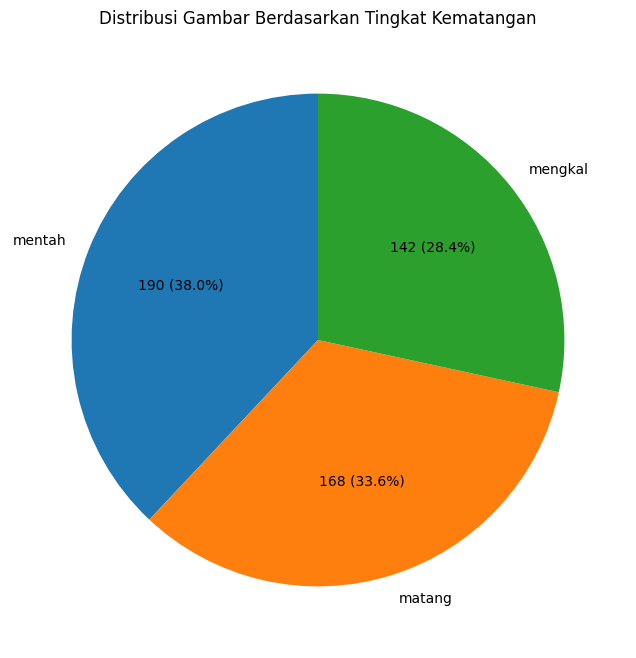

In [11]:
# Asumsikan Anda sudah memiliki DataFrame 'df' dengan kolom 'category'

# Hitung jumlah gambar per kategori
data = df['category'].value_counts()

# Buat pie chart
plt.figure(figsize=(8, 8))
plt.pie(data, labels=data.index, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p*sum(data)/100, p), startangle=90)
plt.title('Distribusi Gambar Berdasarkan Tingkat Kematangan')
plt.show()

In [12]:
# Menampilkan 5 gambar berdasarkan masing-masing tingkat kematangan
fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for i, category in enumerate(['mentah', 'mengkal', 'matang']):
    # Mengambil 5 gambar pertama dari kategori ini
    subset = df[df['category'] == category].head(5)
    for j, (index, row) in enumerate(subset.iterrows()):
        img = Image.open(row['filepath'])
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(category.capitalize(), size=15)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [13]:
# prompt: Saya ingin melakukan preprocessing data berdasarkan fitur warna. supaya gambarnya sama rata tolong dicrop tanpa memotong objek. dan kasih tau jika processing datanya sudah selesai

def preprocess_image(image_path):
  # Buka gambar
  img = Image.open(image_path)

  # Tentukan ukuran crop yang sesuai (misalnya, 80% dari ukuran asli)
  crop_width = int(img.width * 0.8)
  crop_height = int(img.height * 0.8)

  # Tentukan koordinat tengah gambar
  center_x = img.width // 2
  center_y = img.height // 2

  # Hitung koordinat kiri atas dan kanan bawah untuk cropping
  left = center_x - crop_width // 2
  top = center_y - crop_height // 2
  right = center_x + crop_width // 2
  bottom = center_y + crop_height // 2

  # Crop gambar
  cropped_img = img.crop((left, top, right, bottom))

  # Ubah ukuran gambar ke ukuran yang diinginkan (misalnya, 224x224)
  resized_img = cropped_img.resize((224, 224))

  # Konversi gambar ke array numpy
  img_array = np.array(resized_img)

  return img_array

# Terapkan preprocessing ke semua gambar
preprocessed_images = []
preprocessed_labels = []

for index, row in df.iterrows():
  image_path = row['filepath']
  label = row['target']

  preprocessed_image = preprocess_image(image_path)

  preprocessed_images.append(preprocessed_image)
  preprocessed_labels.append(label)

# Konversi list ke array numpy
X = np.array(preprocessed_images)
y = np.array(preprocessed_labels)

print("Preprocessing data selesai.")


Preprocessing data selesai.


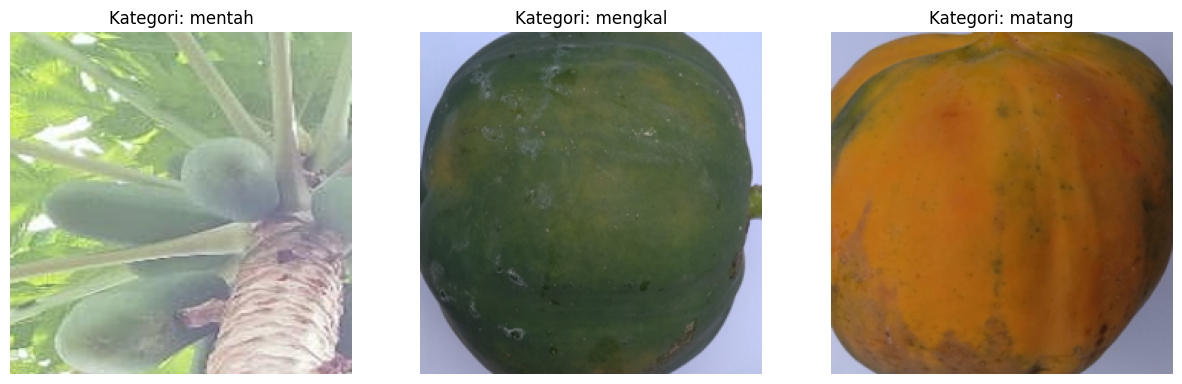

In [14]:
# Menampilkan satu gambar per kelas
plt.figure(figsize=(15, 5))
for i, category in enumerate(['mentah', 'mengkal', 'matang']):
    # Mencari indeks gambar pertama dalam kategori ini
    index = df[df['category'] == category].index[0]

    # Menampilkan gambar
    plt.subplot(1, 3, i+1)
    plt.imshow(X[index])
    plt.title(f"Kategori: {category}")
    plt.axis('off')

plt.show()


In [15]:
def extract_color_features(image):
  # Konversi ke ruang warna RGB
  rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Hitung rata-rata nilai RGB
  mean_rgb = np.mean(rgb_image, axis=(0, 1))

  # Konversi ke ruang warna HSV
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  # Hitung rata-rata nilai HSV
  mean_hsv = np.mean(hsv_image, axis=(0, 1))

  # Gabungkan fitur warna RGB dan HSV
  color_features = np.concatenate((mean_rgb, mean_hsv))

  return color_features

# Inisialisasi list untuk menyimpan fitur warna
color_features_list = []

# Ekstrak fitur warna untuk setiap gambar
for image in X:
  color_features = extract_color_features(image)
  color_features_list.append(color_features)

# Konversi list fitur warna ke array numpy
color_features_array = np.array(color_features_list)

print("Fitur warna telah diekstrak.")


Fitur warna telah diekstrak.


In [16]:
# Cek bentuk array fitur warna
print("Bentuk array fitur warna:", color_features_array.shape)

# Cetak beberapa fitur warna pertama untuk verifikasi
print("Beberapa fitur warna pertama:")
print(color_features_array[:5])


Bentuk array fitur warna: (500, 6)
Beberapa fitur warna pertama:
[[151.31997369 180.52656649 166.92715641  76.18959263  46.32776626
  183.33484136]
 [ 63.95125159  71.91438138  56.11860252  47.93365354  80.39259805
   77.66780931]
 [ 47.55414939 135.92869101 107.19581075  77.59022242 186.66669324
  140.0057398 ]
 [ 90.53216677 160.07108976 121.89598613  67.18387277 137.86557318
  163.1495735 ]
 [ 66.94917889 169.89630501 117.77686543  74.41035555 164.43271684
  170.42637915]]


In [17]:
# Inisialisasi StandardScaler
scaler = StandardScaler()

# Fit scaler ke data fitur warna dan transform data
scaled_color_features = scaler.fit_transform(color_features_array)

print("Data augmentasi pada fitur warna telah selesai.")

# Cetak beberapa fitur warna yang telah diskalakan untuk verifikasi
print("Beberapa fitur warna yang telah diskalakan:")
print(scaled_color_features[:5])


Data augmentasi pada fitur warna telah selesai.
Beberapa fitur warna yang telah diskalakan:
[[ 3.25951101  2.01487604  1.34961233 -0.22998403 -2.03383595  1.57800323]
 [-0.17227355 -1.1320967  -1.57981512 -1.9173234  -1.1784431  -1.45387998]
 [-0.81634069  0.72267942 -0.2294954  -0.14634364  1.49017719  0.33476991]
 [ 0.87180689  1.4221909   0.15913071 -0.76777206  0.26474536  0.99883134]
 [-0.05451699  1.70687061  0.0502342  -0.33623344  0.93186577  1.20762328]]


In [18]:
# Cetak ukuran shape dari scaled_color_features
print("Ukuran shape dari scaled_color_features:", scaled_color_features.shape)


Ukuran shape dari scaled_color_features: (500, 6)


In [19]:
# # Definisikan model InceptionV3 yang telah dioptimasi
# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Bekukan lapisan-lapisan dasar
# for layer in base_model.layers:
#   layer.trainable = False

# # Tambahkan lapisan-lapisan baru di atas model dasar
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)

# # Tambahkan lapisan input untuk fitur warna
# color_input = Input(shape=(scaled_color_features.shape[1],))
# color_dense = Dense(64, activation='relu')(color_input)

# # Gabungkan fitur warna dengan output dari model InceptionV3
# combined_features = tf.keras.layers.concatenate([x, color_dense])

# # Tambahkan lapisan output untuk klasifikasi
# predictions = Dense(3, activation='softmax')(combined_features)  # 3 kelas untuk klasifikasi

# # Buat model akhir
# model = Model(inputs=[base_model.input, color_input], outputs=predictions)

# # Cetak ringkasan model
# model.summary()


In [20]:
# class ETACallback(Callback):
#     def on_epoch_begin(self, epoch, logs=None):
#         self.start_time = time.time()
#         self.epochs = self.params['epochs']
#         self.epoch = epoch

#     def on_epoch_end(self, epoch, logs=None):
#         elapsed_time = time.time() - self.start_time
#         remaining_epochs = self.epochs - (epoch + 1)
#         eta = elapsed_time * remaining_epochs
#         print(f"\nEpoch {epoch + 1}/{self.epochs} - ETA: {eta:.2f} seconds")

# # Kompilasi model
# model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Bagi data menjadi data latih dan data validasi
# X_train, X_val, y_train, y_val, color_features_train, color_features_val = train_test_split(
#     X, y, scaled_color_features, test_size=0.2, random_state=42
# )

# # Latih model dengan callback ETA
# history = model.fit(
#     [X_train, color_features_train], y_train,
#     epochs=50,  # Ganti dengan jumlah epoch yang diinginkan
#     batch_size=32,  # Ganti dengan ukuran batch yang diinginkan
#     validation_data=([X_val, color_features_val], y_val),
#     callbacks=[ETACallback()]
# )

In [21]:
# Fungsi untuk membuat model
def create_model(input_shape, color_input_shape):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Bekukan lapisan-lapisan dasar
    for layer in base_model.layers:
        layer.trainable = False

    # Tambahkan lapisan-lapisan baru di atas model dasar
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Tambahkan lapisan input untuk fitur warna
    color_input = Input(shape=(color_input_shape,))
    color_dense = Dense(64, activation='relu')(color_input)

    # Gabungkan fitur warna dengan output dari model InceptionV3
    combined_features = tf.keras.layers.concatenate([x, color_dense])

    # Tambahkan lapisan output untuk klasifikasi
    predictions = Dense(3, activation='softmax')(combined_features)  # 3 kelas untuk klasifikasi

    # Buat model akhir
    model = Model(inputs=[base_model.input, color_input], outputs=predictions)

    return model

# Fungsi untuk melatih dan mengevaluasi model
def train_and_evaluate_model(model, X_train, y_train, color_features_train, X_val, y_val, color_features_val, X_test, y_test, color_features_test, epochs=50, batch_size=32):
    # Callback untuk ETA
    class ETACallback(Callback):
        def on_epoch_begin(self, epoch, logs=None):
            self.start_time = time.time()
            self.epochs = self.params['epochs']
            self.epoch = epoch

        def on_epoch_end(self, epoch, logs=None):
            elapsed_time = time.time() - self.start_time
            remaining_epochs = self.epochs - (epoch + 1)
            eta = elapsed_time * remaining_epochs
            print(f"\nEpoch {epoch + 1}/{self.epochs} - ETA: {eta:.2f} seconds")

    # Kompilasi model
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Latih model dengan callback ETA
    history = model.fit(
        [X_train, color_features_train], y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([X_val, color_features_val], y_val),
        callbacks=[ETACallback()]
    )

    # Evaluasi model pada data uji
    test_loss, test_accuracy = model.evaluate([X_test, color_features_test], y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    return test_accuracy

In [22]:
# Inisialisasi model untuk mencetak ringkasan
input_shape = (224, 224, 3)  # Ukuran input gambar
color_input_shape = scaled_color_features.shape[1]  # Dimensi fitur warna
model = create_model(input_shape, color_input_shape)

# Cetak ringkasan model hanya sekali
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,066,083 (84.18 MB)

 Trainable params: 263,299 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [23]:
# Rasio pembagian
ratios = [(0.1, 0.1), (0.2, 0.2), (0.3, 0.3)]  # (data_uji, data_validasi) dari total data

# Untuk menyimpan hasil
results = []

best_accuracy = 0
best_model = None

for test_ratio, val_ratio in ratios:
    # Pisahkan data menjadi data latih, validasi, dan uji
    X_train_val, X_test, y_train_val, y_test, color_features_train_val, color_features_test = train_test_split(
        X, y, scaled_color_features, test_size=test_ratio, random_state=42
    )

    X_train, X_val, y_train, y_val, color_features_train, color_features_val = train_test_split(
        X_train_val, y_train_val, color_features_train_val, test_size=val_ratio / (1 - test_ratio), random_state=42
    )

    # Buat model baru untuk setiap rasio
    model = create_model(input_shape, color_input_shape)

    # Latih dan evaluasi model
    accuracy = train_and_evaluate_model(
        model, X_train, y_train, color_features_train,
        X_val, y_val, color_features_val,
        X_test, y_test, color_features_test
    )

    # Simpan hasil
    results.append({'Test Ratio': test_ratio, 'Validation Ratio': val_ratio, 'Test Accuracy': accuracy})

    # Simpan model dengan akurasi terbaik
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# Simpan model terbaik
if best_model is not None:
    best_model.save('best_model.h5')
    print(f"Model terbaik dengan akurasi {best_accuracy:.4f} telah disimpan.")

# Tampilkan hasil
results_df = pd.DataFrame(results)
results_df.head()

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4027 - loss: 20.5590
Epoch 1/50 - ETA: 3377.19 seconds
13/13 ━━━━━━━━━━━━━━━━━━━━ 69s 5s/step - accuracy: 0.4079 - loss: 20.1624 - val_accuracy: 0.7200 - val_loss: 2.3737
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6213 - loss: 4.9469
Epoch 2/50 - ETA: 4215.66 seconds
13/13 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - accuracy: 0.6207 - loss: 4.8668 - val_accuracy: 0.8200 - val_loss: 1.2852
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6913 - loss: 1.1201
Epoch 3/50 - ETA: 3507.65 seconds
13/13 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.6917 - loss: 1.1130 - val_accuracy: 0.8400 - val_loss: 0.7256
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7664 - loss: 0.6175
Epoch 4/50 - ETA: 2351.16 seconds
13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.7664 - loss: 0.6177 - val_accuracy: 0.7800 - val_loss: 0.6304
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7239 - 

Test Accuracy: 0.8733
Model terbaik dengan akurasi 0.9400 telah disimpan.


,Test Ratio,Validation Ratio,Test Accuracy
0,0.1,0.1,0.940000
1,0.2,0.2,0.890000
2,0.3,0.3,0.873333


In [24]:
# model.save('papaya_model.h5')

In [25]:
# Load the saved model
loaded_model = load_model('/content/best_model.h5')

In [26]:
# Set a custom style (optional)
sns.set_style("darkgrid")

# Plot accuracy curve with more customization
plt.figure(figsize=(20, 10))
plt.plot(history.history['accuracy'], label='Akurasi Training', color='blue', linestyle='-') # Use history.history to access the data
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi', color='orange', linestyle='--')
plt.title('Perbandingan Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Add epoch annotations on the accuracy curve
for i, acc in enumerate(history.history['accuracy']):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', va='bottom', fontsize=10, color='blue')

# Plot loss curve with more customization
plt.figure(figsize=(20, 10))
plt.plot(history.history['loss'], label='Loss Training', color='red', linestyle='-')
plt.plot(history.history['val_loss'], label='Loss Validasi', color='purple', linestyle='--')
plt.title('Perbandingan Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Add loss annotations on the loss curve
for i, loss in enumerate(history.history['loss']):
    plt.text(i, loss + 0.02, f'{loss:.2f}', ha='center', va='bottom', fontsize=10, color='red')

plt.show()

NameError: name 'history' is not defined

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# Prediksi pada data validasi
y_pred_proba = loaded_model.predict([X_val, color_features_val])
y_pred = np.argmax(y_pred_proba, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Tampilkan confusion matrix menggunakan seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# prompt: kemudian saya ingin menampilkan nilai classification report

# Tampilkan classification report
print(classification_report(y_val, y_pred, target_names=['mentah', 'mengkal', 'matang']))


In [ ]:
# prompt: kemudian saya ingin menampilkan ROC Curve keseluruhan saja

# Hitung nilai prediksi probabilitas untuk setiap kelas
y_pred_proba = loaded_model.predict([X_val, color_features_val])

# Hitung ROC curve dan AUC untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3  # Jumlah kelas
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Hitung micro-average ROC curve dan AUC
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_val).ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot micro-average ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# prompt: kemudian saya ingin menampilkan nilai akurasi, presisi, recall, f-1 score dari ketiga kelas

# Hitung precision, recall, dan F1-score untuk setiap kelas
precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred, average=None)

# Tampilkan hasil
for i, label in enumerate(['mentah', 'mengkal', 'matang']):
    print(f"Kelas {label}:")
    print(f"  Akurasi: {cm[i, i] / sum(cm[i, :]):.2f}")
    print(f"  Presisi: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-score: {f1_score[i]:.2f}")
    print()


In [ ]:
# Global DataFrame untuk menyimpan hasil
df_results = pd.DataFrame(columns=['Mean_R', 'Mean_G', 'Mean_B', 'Mean_H', 'Mean_S', 'Mean_V', 'Prediction'])

def process_uploaded_image():
    global df_results  # Mengakses DataFrame global
    try:
        # Mengunggah file
        uploaded = files.upload()

        # Jika tidak ada file yang diupload (mungkin karena dibatalkan)
        if not uploaded:
            return

        # List untuk menyimpan hasil prediksi dari gambar yang baru di-upload
        new_results = []

        for fn in uploaded.keys():
            # Preprocessing gambar
            path = fn
            img = preprocess_image(path)

            # Konversi ke RGB jika ada saluran alpha
            if img.shape[2] == 4:  # Check if the image has 4 channels (RGBA)
                img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)  # Convert RGBA to RGB

            x = np.expand_dims(img, axis=0)

            # Ekstrak fitur warna dari gambar yang diunggah
            color_features_uploaded = extract_color_features(img)

            # Skala fitur warna menggunakan scaler yang sama yang digunakan untuk data pelatihan
            scaled_color_features_uploaded = scaler.transform(color_features_uploaded.reshape(1, -1))

            # Melakukan prediksi dengan model yang telah dilatih
            images = np.vstack([x])
            classes = loaded_model.predict([images, scaled_color_features_uploaded], batch_size=10)
            result = np.argmax(classes)

            # Simpan hasil prediksi dari gambar yang baru di-upload
            result_row = np.append(scaled_color_features_uploaded.flatten(), result).tolist()
            new_results.append(result_row)

            # Tampilkan hasil prediksi untuk gambar yang baru di-upload
            if result == 0:
                print(f"Image '{fn}' is mentah")
            elif result == 1:
                print(f"Image '{fn}' is mengkal")
            elif result == 2:
                print(f"Image '{fn}' is matang")

            plt.imshow(img)
            plt.title(f"Prediction: {result}")
            plt.show()

        # Membuat DataFrame dari hasil gambar yang baru di-upload
        df_new_results = pd.DataFrame(new_results, columns=['Mean_R', 'Mean_G', 'Mean_B', 'Mean_H', 'Mean_S', 'Mean_V', 'Prediction'])

        # Gabungkan hasil baru dengan DataFrame global
        df_results = pd.concat([df_results, df_new_results], ignore_index=True)

        # Tampilkan DataFrame hasil
        print("DataFrame Hasil:")
        print(df_results)

    except Exception as e:
        print("Upload dibatalkan atau terjadi kesalahan:", e)

def repeat_upload():
    while True:
        process_uploaded_image()
        # Opsi: menghentikan loop setelah proses upload jika diinginkan
        cont = input("Apakah Anda ingin mengupload gambar lain? (y/n): ").strip().lower()
        if cont != 'y':
            break  # Menghentikan loop jika tidak ada upload gambar lebih lanjut

# Mulai proses upload dan pemrosesan
repeat_upload()

In [ ]:
# prompt: kemudian tampilkan dataframe

# Assuming 'df_results' is the DataFrame from the previous code
if 'df_results' in locals():
  display(df_results)
else:
  print("DataFrame 'df_results' tidak ditemukan.")


In [ ]:
# prompt: kemudian masukkan nilai kematangannya jika nilai prediksinya 2 maka kategori buah tersebut hanya dijual dalam daerah itu saja. jika nilai prediksinya 1  maka dapat dikirim antar kabupaten. dan jika nilai prediksinya 0 maka bisa dikirim keluar daerah

# Menambahkan kolom 'Keterangan' berdasarkan nilai 'Prediction'
df_results['Keterangan'] = df_results['Prediction'].apply(lambda x:
    'Dijual dalam daerah saja' if x == 2
    else ('Dapat dikirim antar kabupaten' if x == 1
          else 'Bisa dikirim keluar daerah')
)

# Menampilkan DataFrame yang telah diperbarui
display(df_results)


In [ ]:
# prompt: kemudian lakukan penghapusan outlier saja dari RGB sampai HSV

import numpy as np
from scipy import stats

# Pilih kolom yang akan diperiksa outliernya
columns_to_check = ['Mean_R', 'Mean_G', 'Mean_B', 'Mean_H', 'Mean_S', 'Mean_V']

# Hitung z-score untuk setiap nilai dalam kolom yang dipilih
z_scores = np.abs(stats.zscore(df_results[columns_to_check]))

# Tentukan ambang batas untuk outlier (misalnya, 3 deviasi standar)
threshold = 3

# Temukan indeks baris dengan outlier
outlier_indices = np.where(z_scores > threshold)[0]

# Hapus outlier dari DataFrame
df_filtered = df_results.drop(outlier_indices)

# Tampilkan DataFrame yang telah difilter
print("DataFrame Setelah Penghapusan Outlier:")
display(df_filtered)


In [ ]:
# prompt: kemudian lakukan pca analisis terbaik

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Pilih kolom numerik yang akan digunakan dalam PCA
features = ['Mean_R', 'Mean_G', 'Mean_B', 'Mean_H', 'Mean_S', 'Mean_V']
x = df_filtered.loc[:, features].values

# Skala data
x = StandardScaler().fit_transform(x)

# Inisialisasi PCA dan fit ke data
pca = PCA()
principalComponents = pca.fit_transform(x)

# Buat DataFrame dari komponen utama
principalDf = pd.DataFrame(data = principalComponents)

# Tampilkan variansi yang dijelaskan oleh setiap komponen utama
print("Variansi yang Dijelaskan oleh Setiap Komponen Utama:")
print(pca.explained_variance_ratio_)

# Plot variansi yang dijelaskan oleh setiap komponen utama
plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Jumlah Komponen')
plt.ylabel('Variansi Kumulatif yang Dijelaskan')
plt.title('Variansi yang Dijelaskan oleh Komponen Utama')
plt.show()


In [ ]:
# prompt: kemudian buat penentuan jumlah clusternya berdasarkan nilai silhouettenya. digaris bawahi untuk K Medoid

import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score

# Range jumlah cluster yang akan diuji
range_n_clusters = range(2, 11)

# List untuk menyimpan skor silhouette
silhouette_scores = []

# Loop melalui jumlah cluster yang berbeda
for n_clusters in range_n_clusters:
    # Inisialisasi K-medoids clustering
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=0)

    # Fit model ke data
    cluster_labels = kmedoids.fit_predict(principalDf)  # Menggunakan principalDf dari PCA

    # Hitung skor silhouette
    silhouette_avg = silhouette_score(principalDf, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    print("Untuk n_clusters =", n_clusters, "Skor silhouette rata-rata adalah :", silhouette_avg)

# Plot skor silhouette
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Skor Silhouette Rata-rata')
plt.title('Skor Silhouette untuk Jumlah Cluster yang Berbeda (K-Medoids)')
plt.show()

# Temukan jumlah cluster optimal berdasarkan skor silhouette tertinggi
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print("\nJumlah cluster optimal berdasarkan skor silhouette (K-Medoids):", optimal_n_clusters)

# __Garis bawahi untuk K-Medoids:__
# Jumlah cluster optimal untuk K-Medoids clustering adalah yang memberikan skor silhouette tertinggi.
# Dalam kasus ini, Anda perlu memeriksa plot atau nilai dalam `silhouette_scores` untuk menentukan jumlah cluster optimal.


In [ ]:
# prompt: kemudian lakukan inisialisasi Medoid++ yang terbaik

# Inisialisasi K-medoids clustering dengan Medoid++ dan jumlah cluster optimal
kmedoids = KMedoids(n_clusters=optimal_n_clusters, init='k-medoids++', random_state=0)

# Fit model ke data
cluster_labels = kmedoids.fit_predict(principalDf)  # Menggunakan principalDf dari PCA

# Tampilkan label cluster
print("Label Cluster:")
print(cluster_labels)


In [ ]:
# prompt: kemudian lakukan penggunaan Dissimilarity Matrix

# Hitung Dissimilarity Matrix
dissimilarity_matrix = pairwise_distances(principalDf, metric='euclidean')

# Inisialisasi K-medoids clustering dengan Dissimilarity Matrix dan jumlah cluster optimal
kmedoids = KMedoids(n_clusters=optimal_n_clusters, metric='precomputed', random_state=0)

# Fit model ke Dissimilarity Matrix
cluster_labels_dissimilarity = kmedoids.fit_predict(dissimilarity_matrix)

# Tampilkan label cluster yang diperoleh menggunakan Dissimilarity Matrix
print("\nLabel Cluster (menggunakan Dissimilarity Matrix):")
print(cluster_labels_dissimilarity)


In [ ]:
# prompt: kemudian lakukan iterasi maksimum

# Inisialisasi K-medoids clustering dengan jumlah cluster optimal dan iterasi maksimum
kmedoids = KMedoids(n_clusters=optimal_n_clusters, init='k-medoids++', random_state=0, max_iter=1000)  # Ganti 1000 dengan jumlah iterasi maksimum yang diinginkan

# Fit model ke data
cluster_labels = kmedoids.fit_predict(principalDf)  # Menggunakan principalDf dari PCA

# Tampilkan label cluster
print("Label Cluster (dengan iterasi maksimum):")
print(cluster_labels)


In [ ]:
# prompt: kemudian lakukan evaluasi

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Hitung skor Silhouette
silhouette_avg = silhouette_score(principalDf, cluster_labels)
print("Skor Silhouette:", silhouette_avg)

# Hitung skor Calinski-Harabasz
calinski_harabasz_score_value = calinski_harabasz_score(principalDf, cluster_labels)
print("Skor Calinski-Harabasz:", calinski_harabasz_score_value)

# Hitung skor Davies-Bouldin
davies_bouldin_score_value = davies_bouldin_score(principalDf, cluster_labels)
print("Skor Davies-Bouldin:", davies_bouldin_score_value)


In [ ]:
# prompt: kemudian lakukan validasi pada k medoids dan buat kesimpulannya

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Hitung skor Silhouette
silhouette_avg = silhouette_score(principalDf, cluster_labels)
print("Skor Silhouette:", silhouette_avg)

# Hitung skor Calinski-Harabasz
calinski_harabasz_score_value = calinski_harabasz_score(principalDf, cluster_labels)
print("Skor Calinski-Harabasz:", calinski_harabasz_score_value)

# Hitung skor Davies-Bouldin
davies_bouldin_score_value = davies_bouldin_score(principalDf, cluster_labels)
print("Skor Davies-Bouldin:", davies_bouldin_score_value)

# --- Interpretasi Hasil ---
print("\n--- Interpretasi Hasil ---")
print("Skor Silhouette yang lebih tinggi (mendekati 1) menunjukkan pemisahan cluster yang lebih baik.")
print("Skor Calinski-Harabasz yang lebih tinggi menunjukkan cluster yang lebih padat dan terpisah dengan baik.")
print("Skor Davies-Bouldin yang lebih rendah menunjukkan cluster yang lebih baik dengan jarak antar cluster yang lebih besar dan penyebaran dalam cluster yang lebih kecil.")

# Kesimpulan berdasarkan skor
if silhouette_avg > 0.5:
    print("\nBerdasarkan skor Silhouette, clustering cukup baik.")
else:
    print("\nBerdasarkan skor Silhouette, clustering mungkin perlu ditingkatkan.")

if calinski_harabasz_score_value > 100:  # Nilai ambang batas dapat disesuaikan
    print("Berdasarkan skor Calinski-Harabasz, clustering cukup baik.")
else:
    print("Berdasarkan skor Calinski-Harabasz, clustering mungkin perlu ditingkatkan.")

if davies_bouldin_score_value < 1:  # Nilai ambang batas dapat disesuaikan
    print("Berdasarkan skor Davies-Bouldin, clustering cukup baik.")
else:
    print("Berdasarkan skor Davies-Bouldin, clustering mungkin perlu ditingkatkan.")
